In [1]:
import numpy as np, torch, matplotlib.pyplot as plt
import os
import sys

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, "../src"))

if module_path not in sys.path:
    sys.path.append(module_path)

dpo_path = '../src/best_dpo_policy.pth'

horizon = 500

Creating Path with step 3
Resetting environment. Previous state: [0.05 0.05], Counter: 0


/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_7892/4090792877.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  x_std = _std(torch.tensor(next_raw, dtype=torch.float32, device=device))


Step called. Counter: 0, Horizon: 500
Step called. Counter: 1, Horizon: 500
Step called. Counter: 2, Horizon: 500
Step called. Counter: 3, Horizon: 500
Step called. Counter: 4, Horizon: 500
Step called. Counter: 5, Horizon: 500
Step called. Counter: 6, Horizon: 500
Step called. Counter: 7, Horizon: 500
Step called. Counter: 8, Horizon: 500
Step called. Counter: 9, Horizon: 500
Step called. Counter: 10, Horizon: 500
Step called. Counter: 11, Horizon: 500
Step called. Counter: 12, Horizon: 500
Step called. Counter: 13, Horizon: 500
Step called. Counter: 14, Horizon: 500
Step called. Counter: 15, Horizon: 500
Step called. Counter: 16, Horizon: 500
Step called. Counter: 17, Horizon: 500
Step called. Counter: 18, Horizon: 500
Step called. Counter: 19, Horizon: 500
Step called. Counter: 20, Horizon: 500
Step called. Counter: 21, Horizon: 500
Step called. Counter: 22, Horizon: 500
Step called. Counter: 23, Horizon: 500
Step called. Counter: 24, Horizon: 500
Step called. Counter: 25, Horizon: 

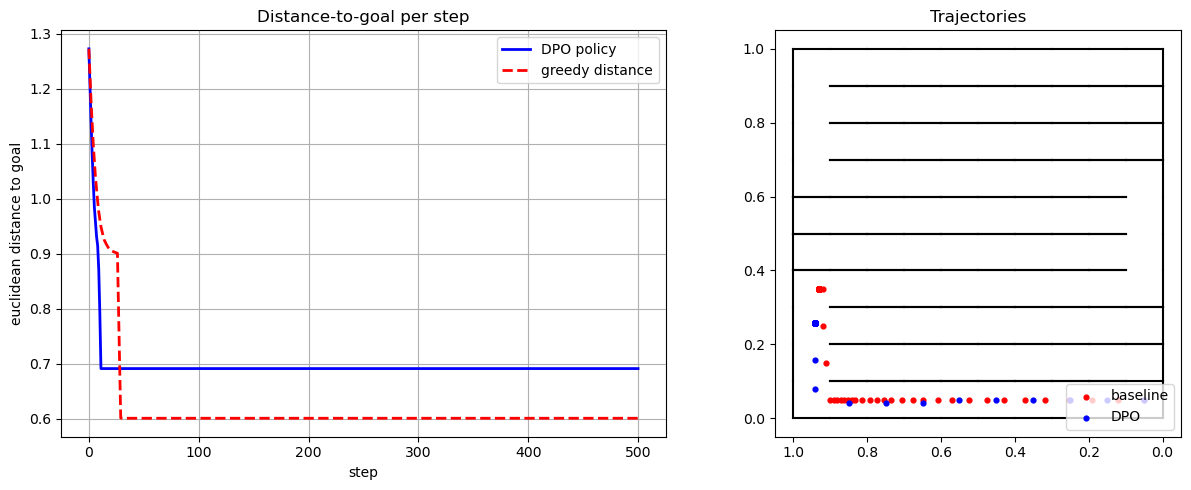

In [2]:
import numpy as np, torch, matplotlib.pyplot as plt
from maze import Maze
from maze_env import MazeEnv, draw_map
from maze_env import PolicyNetwork

# utils.py (o direttamente in make_comparison.ipynb)

def best_improving_action(env, acts, ref_metric, tol=1e-6):
    """
    Ritorna la prima azione che riduce di almeno `tol`
    il valore di ref_metric(s') rispetto a quello corrente.
    Se nessuna azione migliora, restituisce None.
    """
    best_a, best_val = None, ref_metric  # migliore finora (deve essere < ref)
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s1 = env.state + np.array([dx, dy])

        # qui usiamo la distanza al goal come metrica di riferimento
        val = np.linalg.norm(env.goal - s1)

        # opzionale: scarta subito se la mossa collide
        if env.point_collision(s1[0], s1[1]):
            continue

        if val < best_val - tol:
            best_val, best_a = val, a

    return best_a

# ------------------------------------------------------------------
# helper: rollout con politica arbitraria f(state) -> action
# ------------------------------------------------------------------
def rollout(env, policy_fn, max_steps=500):
    if max_steps is None:
        max_steps = env.horizon
    env.reset(state=start.copy())
    traj, dists = [env.state.copy()], [np.linalg.norm(env.goal-env.state)]
    for _ in range(max_steps):
        a = policy_fn(env)
        state, _, done, _, _ = env.step(a)
        traj.append(state.copy())
        dists.append(np.linalg.norm(env.goal - state))
        if done:
            break
    return np.array(traj), dists

def policy_dist_safe(env, tol=1e-6):
    acts = candidate_actions()
    cur_d = np.linalg.norm(env.goal - env.state)
    a = best_improving_action(env, acts, cur_d, tol=tol)
    return a if a is not None else np.zeros(2, dtype=np.float32)  # resta fermo

# ------------------------------------------------------------------
# 1. ambiente + DPO-policy caricata
# ------------------------------------------------------------------
hidden_dim = 256
num_layers = 4
dropout_prob = 0.05

start = np.array([0.05, 0.05])
maze  = Maze(10,10,0,0)
env_dpo = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                  reward="distance", dt=0.1, horizon=horizon, slide=1,
                  use_dpo=True, dpo_model_path=dpo_path, hidden_dim=hidden_dim, num_layers=num_layers, dropout_prob=dropout_prob)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#  --- costanti usate nel training ---
norm = np.load("norm_stats.npz")
MEAN = norm["mean"].astype(np.float32)     # shape (2,)
STD  = norm["std"].astype(np.float32) + 1e-8   # per evitare div/0

def get_norm_tensors(device):
    if not hasattr(get_norm_tensors, "_cache"):
        get_norm_tensors._cache = {}
    if device not in get_norm_tensors._cache:
        get_norm_tensors._cache[device] = (
            torch.tensor(MEAN, device=device),   # <<== torch sul device giusto
            torch.tensor(STD,  device=device)
        )
    return get_norm_tensors._cache[device]

# ---- normalizzazione per l'inferenza ----
def _std(x: torch.Tensor) -> torch.Tensor:
    mean_t, std_t = get_norm_tensors(x.device)   # mai numpy qui
    return (x - mean_t) / std_t



# ------------------------------------------------------------------
# 2. definisci le due politiche
# ------------------------------------------------------------------
angles = np.linspace(-1, 1, 64, endpoint=False, dtype=np.float32)   # 64 direzioni
speeds = [ 0.2, 0.4, 0.6, 0.8, 1.0]                             # più fine sul piccolo                                

def candidate_actions():
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)

# -- DPO: valuta con la rete -----------------------
def policy_dpo(env):
    acts = candidate_actions()
    next_states_raw = []
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        next_states_raw.append(env.state + np.array([dx,dy]))
    # --- inferenza ---
    x = torch.tensor(next_states_raw, dtype=torch.float32, device=device)
    x_std = _std(x)                         # <-- aggiunto
    with torch.no_grad():
        scores = env.policy_net(x_std).cpu().numpy().squeeze()
    return acts[np.argmax(scores)]


def policy_dpo_safe(env, tol_val=1e-8):
    acts = candidate_actions()
    next_raw  = []
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        next_raw.append(env.state + np.array([dx,dy]))

    x_std = _std(torch.tensor(next_raw, dtype=torch.float32, device=device))
    with torch.no_grad():
        scores = env.policy_net(x_std).cpu().numpy().squeeze()

    cur_val = env.evaluate_state_with_dpo(env.state)   # ora è in scala giusta
    for idx in scores.argsort()[::-1]:                 # best-first
        if scores[idx] <= cur_val + tol_val:
            continue
        nx, ny = next_raw[idx]                         # usa le raw!
        if not env.point_collision(nx, ny):
            return acts[idx]
    return np.zeros(2, dtype=np.float32)               # fallback




# -- baseline: minimizza distanza euclidea al goal --
def policy_dist(env):
    acts = candidate_actions()
    best, best_d = None, np.inf
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s  = env.state + np.array([dx,dy])
        d  = np.linalg.norm(env.goal - s)
        if d < best_d and not env.point_collision(s[0], s[1]):
            best_d, best = d, a
    return best if best is not None else acts[0]      # fallback

# ------------------------------------------------------------------
# 3. esegui i due roll-out
# ------------------------------------------------------------------
traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo_safe, max_steps=horizon)
# traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo, max_steps=horizon)

#  per il baseline usiamo **una nuova copia** dell’ambiente (stesso maze!)
env_base = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                   reward="distance", dt=0.1, horizon=horizon, slide=1, use_dpo=False)
traj_base, dist_base = rollout(env_base, policy_dist_safe, max_steps=horizon)

# ------------------------------------------------------------------
# 4. plotting comparativo
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(13,5))

# --- distanza vs step
axes[0].plot(dist_dpo,  label="DPO policy",  lw=2, color='blue')
axes[0].plot(dist_base, label="greedy distance", lw=2, ls="--", color='red')
axes[0].set_xlabel("step")
axes[0].set_ylabel("euclidean distance to goal")
axes[0].set_title("Distance-to-goal per step")
axes[0].legend(); axes[0].grid(True)

# --- traiettorie
draw_map(1/env_dpo.sz, env_dpo.maze, ax=axes[1], alpha=1.0)

# Traiettoria Baseline (greedy distance) con colore rosso solido
if len(traj_base) > 0:
    axes[1].scatter(traj_base[:,0], traj_base[:,1],
                    color="red",  # Modifica: colore rosso solido
                    s=12, label="baseline")
else:
    axes[1].scatter([],[], color="red", s=12, label="baseline") # Per la legenda se vuota

# Traiettoria DPO con colore blu solido
if len(traj_dpo) > 0:
    axes[1].scatter(traj_dpo[:,0], traj_dpo[:,1],
                    color="blue", # Modifica: colore blu solido
                    s=12, label="DPO")
else:
    axes[1].scatter([],[], color="blue", s=12, label="DPO") # Per la legenda se vuota


axes[1].invert_xaxis(); axes[1].set_aspect("equal")
axes[1].set_title("Trajectories")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()